In [ ]:
!python --version

In [ ]:
#!/usr/bin/env python3
# -*- coding: UTF-8 -*-

from __future__ import absolute_import, division, print_function

import logging

import os
import time

import imageio
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf  # TensorFlow 2.0
# 导入 全连接层、批量标准化层、带泄露的激活函数、激活函数
from tensorflow.keras.layers import (Activation, BatchNormalization, Conv2D,
                                     Conv2DTranspose, Dense, Dropout,
                                     Embedding, Flatten, Input, LeakyReLU,
                                     ReLU, Reshape, ZeroPadding2D)
# 导入常用模型
from tensorflow.keras.models import Model, Sequential
# 导入常用优化器Adam
from tensorflow.keras.optimizers import Adam

# 确保运行环境是 TensorFlow 2.0环境
assert tf.__version__.startswith('2')

logging.getLogger("tensorflow").setLevel(logging.ERROR)


class InfoGAN_FashionMNIST():
    def __init__(self, laten_dim=62, num_classes=10, code_dim=2, name='InfoGAN_FashionMNIST'):
        """ 构建InfoGAN在MNIST数据集上的模型及其训练器。
        参数：
            laten_dim   ：潜在空间的长度，随机噪声部分的长度
            num_classes ：类别标签的长度，在MNIST例子中，共有0-9，共有10个数字
            code_dim    ：代表潜在特征的code长度，在本例中是2。
            name        ：InfoGan的名称，用于保存模型和生成的图片的路径
        """
        self.laten_dim = laten_dim
        self.num_classes = num_classes
        self.code_dim = code_dim
        # 总的随机噪声的长度，包含类别（1个）和代码（2个）的长度
        self.z_dim = self.laten_dim+self.num_classes+self.code_dim
        self.name = name
        # 模型保存的地址
        self.model_dir = "./logs/{}/model/".format(self.name)
        self.keep_checkpoint_max = 5

        # 构建InfoGAN模型
        self.build_info_gan()

        # 静态的随机噪声，保持不变，以便于在不同的训练阶段对图片进行采样，
        # 比较生成图片的变化
        self.static_z = tf.random.normal(
            [self.num_classes ** 2, self.laten_dim])

        # 检查点保存函数，用于从上一次保存点继续训练
        self.checkpoint = tf.train.Checkpoint(
            # 训练的轮次，保存起来。在多次训练中，持续增长。
            epoch=tf.Variable(1),
            # 训练的步数（全局步数，global steps）。在多次训练中，持续增长。
            step=tf.Variable(1),
            # 采样生成图片时，使用的静态随机噪声，以便于观察随着生成模型
            # 训练的增加，生产图片质量变化
            static_z=tf.Variable(self.static_z, trainable=False),

            # 保存生成模型、辨别模型、辅助类别分类器、代码预测器和互信息训练器
            generator=self.generator,
            discriminator=self.discriminator,
            auxilliary=self.auxilliary,
            code=self.code,
            # 互信息训练器，将生成模型和互信息预期器连接起来，同时训练生成模型和
            # 互信息预期器的参数
            m_trainner=self.m_trainner
        )

    def restore_checkpoint(self, manager):
        """ 从上一次训练保存的检查点恢复模型
        参数：
            manager：检查点管理对象
        """
        print("从上一次保存点恢复：{}\n".format(manager.latest_checkpoint))
        self.epoch = self.checkpoint.epoch
        self.step = self.checkpoint.step
        self.static_z = self.checkpoint.static_z

        self.generator = self.checkpoint.generator
        self.discriminator = self.checkpoint.discriminator
        self.code = self.checkpoint.code
        self.m_trainner = self.checkpoint.m_trainner

    def build_info_gan(self):
        """ 构建InfoGAN模型。"""

        # 优化器，初始化学习率：0.0002，beta_1参数：0.5
        optimizer = Adam(0.0002, 0.5)

        # 构建辨别模型、辅助类别预测模型、类别代码预测模型
        self.discriminator, self.auxilliary, self.code = \
            self.infogan_discriminator()

        # 编译辨别模型，辨别模型的输出“是/否”，典型的二分问题，所以，误差
        # 函数采用'binary_crossentropy'
        self.discriminator.compile(
            loss=['binary_crossentropy'], optimizer=optimizer,
            metrics=['accuracy'])

        # 编译辅助类别预测模型，类别预测的结果是one-hot类型的张量，共有10个分类
        # 分别代码数字0-9，所以，误差函数采用'categorical_crossentropy'
        self.auxilliary.compile(
            loss=['categorical_crossentropy'], optimizer=optimizer,
            metrics=['accuracy'])

        # 构建生成模型
        self.generator = self.infogan_generator()

        # 生成模型的输入，包括随机噪声、类别标签、代表隐藏信息代码
        noise_input = Input(shape=(self.laten_dim))
        label_input = Input(shape=(1), dtype=tf.int32)
        code_input = Input(shape=(2), dtype=tf.float32)

        # 调用生成模型生成图片，并调用辅助类别预测模型和隐藏信息代码预测模型预测
        gen_imgs = self.generator([noise_input, label_input, code_input])
        pred_label = self.auxilliary(gen_imgs)
        pred_code = self.code(gen_imgs)

        # 构建互信息训练器，将生成模型和类别预测模型及隐藏信息代码预测模型连接起来
        # 注意，该训练器有两个输出（类别预测结果、互信息预测结果），对应两个损失。
        self.m_trainner = Model(
            [noise_input, label_input, code_input],
            [pred_label, pred_code])
        # 对应的损失函数也有两个，分别是'categorical_crossentropy', 'mse'
        # loss_weights 代表两个损失的权重，权重越大优化的越好。由于类别标签在
        # auxilliary训练时已经优化，所以，可以适当增加互信息损失权重（默认0.1）
        self.m_trainner.compile(
            loss=['categorical_crossentropy', 'mse'],
            loss_weights=[1.0, 0.5],
            optimizer=optimizer)

        # 固定住辨别模型的参数，优化生成模型
        self.discriminator.trainable = False
        # 调用辨别模型生成预测结果（来源于真实样本、还是来源生成模型）
        pred_valid = self.discriminator(gen_imgs)
        # 生成模型训练器(堆叠生成模型和辨别模型)
        self.g_trainner = Model(
            [noise_input, label_input, code_input],
            [pred_valid])
        # 编译生成模型训练器。
        self.g_trainner.compile(
            loss=['binary_crossentropy'], optimizer=optimizer,
            metrics=['accuracy'])

    def infogan_generator(self):
        """ 构建生成模型 """
        model = Sequential(name='infogan_generator')
        # 第一层，全连接层，包含256*7*7个神经元
        model.add(Dense(256*7*7, input_dim=self.laten_dim +
                        self.num_classes+self.code_dim))
        model.add(BatchNormalization(momentum=0.8))
        model.add(ReLU())
        # 形状重整，为后续的反卷积做准备
        model.add(Reshape(target_shape=(7, 7, 256)))
        # 第二层，反卷积层，采用128个、尺寸为3×3、步长为1、
        # 填充方式为same
        model.add(Conv2DTranspose(
            128, 3, strides=(1, 1), padding='same'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(ReLU())

        # 第三层，反卷积层，采用64个、尺寸为3、步长为2的反卷积层
        model.add(Conv2DTranspose(
            64, 3, strides=(2, 2), padding='same'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(ReLU())

        # 第四层，反卷积层，采用1个、尺寸为3、步长为2反卷积层
        model.add(Conv2DTranspose(
            1, 3, strides=(2, 2), padding='same', activation='tanh'))

        # 打印生成模型的详细信息
        model.summary()

        # 构建生成模型的输入，包括随机噪声、类别标签、互信息代码
        noise_input = Input(shape=(self.laten_dim,))
        label_input = Input(shape=(1,), dtype=tf.int32)
        code_input = Input(shape=(2,))

        # one-hot 的类别标签
        one_hot_label = tf.one_hot(
            label_input, self.num_classes, dtype=tf.float32)
        one_hot_label = tf.reshape(one_hot_label, shape=(-1, 10))

        # 将随机噪声、类别标签、互信息代码 串联起来
        gen_input = tf.concat([noise_input, one_hot_label, code_input], axis=1)
        # 调用生成模型生成图片
        img = model(gen_input)

        return Model([noise_input, label_input, code_input], img)

    def infogan_discriminator(self):
        """ 构建辨别模型 """
        model = Sequential(name='infogan_discriminator')
        # 第一层，卷积层，采用16个、尺寸为3、步长为2的卷积操作
        # 输入张量形状[28,28,1],输出张量形状[14,14,16]
        model.add(Conv2D(
            16, 3, strides=(2, 2),
            input_shape=(28, 28, 1), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(rate=0.25))

        # 第二层，卷积层，采用32个、尺寸为3、步长为2的卷积操作
        # 输入张量形状[14,14,16],输出张量形状[7,7,32]
        model.add(Conv2D(
            32, 3, strides=(2, 2), padding='same'))
        model.add(LeakyReLU(0.2))
        model.add(Dropout(0.25))

        # 第三层，卷积层，采用64个、尺寸为3、步长为2的卷积操作
        # 输入张量形状[7,7,32],输出张量形状[4,4,64]
        model.add(Conv2D(
            64, 3, strides=(2, 2), padding='same'))
        model.add(LeakyReLU(0.2))
        model.add(Dropout(0.25))

        # 第四层，卷积层，采用128个、尺寸为3、步长为2的卷积操作
        # 输入张量形状[4,4,64],输出张量形状[2,2,128]
        model.add(Conv2D(
            128, 3, strides=(2, 2), padding='same'))
        model.add(LeakyReLU(0.2))
        model.add(Dropout(0.25))

        # 第五层，展平，为了跟后面的三个全连接分枝连接
        model.add(Flatten())
        # 打印生成模型的详细信息
        model.summary()

        # 构建辨别模型的输入，形状为(28，28，1)的张量
        img = Input(shape=(28, 28, 1))
        img_embedding = model(img)

        # 辨别模型的输出，一个神经元，激活函数'sigmoid'
        validity = Dense(1, activation='sigmoid')(img_embedding)

        # 辅助类别预测模型
        q_net = Dense(128)(img_embedding)
        # 输出10个类别（代表0-9，供10个数字）
        label = Dense(self.num_classes)(q_net)
        # 采用'softmax'作为最终的预测结果
        label = tf.keras.layers.Softmax()(label)

        # 互信息预测结果（共有两个互信息，所以，输出神经元是2个）
        code = Dense(2)(img_embedding)

        # 返回辨别模型、辅助类别预测模型、互信息预测模型
        return Model(img, validity), Model(img, label), Model(img, code)

    def _save_images(self, generator, epoch, step, name, code):
        """
        利用生成模型生成图片，然后，保存到指定的文件夹下。

        参数：
            generator   : 生成模型，已经经过epoch轮训练。
            epoch   : 训练的轮数。
            step    : 训练的步骤数。
            name    : 字符串，分别是'static_z','code_1','code_2'
            code    : 互信息的代码，代表隐含的潜在特征
        """
        image_dir = './logs/{}/image/{}/'.format(self.name, name)
        os.makedirs(image_dir, exist_ok=True)

        # 输出10行、10列，共计100个手写数字图片
        rows, cols = 10, 10
        fig, axs = plt.subplots(rows, cols)
        for i in range(rows):
            # 随机噪声
            noise = np.random.normal(0, 1, (cols, self.laten_dim))
            # 每次生成一个数字，供10次，分别是0-9
            sampled_labels = tf.reshape([i]*cols, (-1, 1))

            # 生成图片数据
            gen_imgs = generator.predict([noise, sampled_labels, code])

            # 将生成的图片数据从[-1, 1]映射到[0, 255]
            gen_imgs = gen_imgs * 127.5 + 127.5

            for j in range(cols):
                axs[i, j].imshow(gen_imgs[j, :, :, 0], cmap='gray')
                axs[i, j].axis('off')

        # 逐级创建目录，如果目录已存在，则忽略
        os.makedirs(image_dir, exist_ok=True)
        # 保存图片
        tmp = os.path.join(
            image_dir, 'image_{:04d}_{:05d}.png')
        image_file_name = tmp.format(epoch+1, step)
        fig.savefig(image_file_name)
        plt.close()

        # 打印日志
        tmp = "第{}轮，第{}步, 保存图片：{}"
        print(tmp.format(epoch+1, step, image_file_name))

    def save_images(self, generator, epoch, step):
        """ 保存图片，分别保存三个类别的图片，包括静态图片、code_1、code_2变化的图片 """
        # 生成静态图片，仅控制类别信息，code都输入0（代表不生成包含隐含特征的信息）
        static_code = tf.zeros(shape=(self.num_classes, 2))
        self._save_images(generator, epoch, step, 'static', static_code)

        # 生成互信息的两个部分，
        zeros = tf.zeros(shape=(self.num_classes, 1))
        var = tf.range(-1.0, 1.0, 2.0/self.num_classes, dtype=tf.float32)
        var = tf.reshape(var, shape=(self.num_classes, 1))

        # 构建只包含第一个隐含特征的代码（code_1）
        # 生成并且保存隐含第一个隐含特征的图片
        code_1 = tf.concat([var, zeros], axis=-1)
        self._save_images(generator, epoch, step, 'code_1', code_1)

        # 构建只包含第二个隐含特征的代码（code_2），并且保存图片
        code_2 = tf.concat([zeros, var], axis=-1)
        self._save_images(generator, epoch, step, 'code_2', code_2)
        # 打印一个空行，让日志更清晰
        print()

    def read_mnist(self, buffer_size, batch_size):
        """
        读取MNIST数据集。

        参数：
            buffer_size：乱序排列时，乱序的缓存大小。
            batch_size：批处理的大小
        Return：
            训练样本数据集。
        """
        # 读取FashionMNIST样本数据
        (train_images, train_labels), (_, _) = \
            tf.keras.datasets.fashion_mnist.load_data()

        # 将图像维度从[28, 28]扩展到[28, 28, 1]
        train_images = tf.expand_dims(train_images, axis=-1)
        # 将MNSIT的像素取值区间从[0, 255]映射到[-1， 1]区间，因为InfoGAN的生成模型
        # 最后一次采用'tanh'作为激活函数，'tanh'输出的取值范围[-1, 1]，样本数据需要
        # 与它一致。
        train_images = (tf.cast(train_images, tf.float32) - 127.5) / 127.5
        train_labels = tf.cast(train_labels, tf.int32)

        # 对样本数据进行乱序排列、并按照batch_size大小划分成不同批次数据
        train_ds = tf.data.Dataset.from_tensor_slices(
            (train_images, train_labels))
        # 如果机器的内存较大，建议设置较大buffer_size
        train_ds = train_ds.prefetch(buffer_size).shuffle(buffer_size)

        # drop_remainder=True，如果最后一个批次样本数据个数少于batch_size时，丢弃
        # 这样可以保障所有批次的样本数量都一致
        train_ds = train_ds.batch(batch_size, drop_remainder=True)
        return train_ds

    def train(self, dataset, epochs, batch_size,
              show_msg_steps=10, save_checkpoints_steps=100,
              sample_image_steps=200, save_image_func=None):
        """
        GAN模型训练，共训练epochs轮次。

        Args:
            dataset: 训练数据集。
            epochs: 训练轮次
            batch_size: 每个训练批次使用的样本数量。
            show_msg_steps: 每训练多少步，打印一次信息。
            save_checkpoints_steps: 每训练save_image_func步，保存一次模型。
            sample_image_steps: 每训练sample_image_steps步数，保存图片一次。
            save_image_func: 保存生成图片的函数。
        """
        # 检查是否有上一次训练过程中保存的模型
        manager = tf.train.CheckpointManager(
            self.checkpoint, self.model_dir,
            max_to_keep=self.keep_checkpoint_max)
        # 如果有，则加载上一次保存的模型；
        self.checkpoint.restore(manager.latest_checkpoint)

        # 检查是否加载成功
        if manager.latest_checkpoint:
            self.restore_checkpoint(manager)
        else:
            # 使用缺省的生成模型和辨别模型（构建模型训练器时已创建,这里无需创建）
            pass

        # 开始模型训练，计时。
        time_start = time.time()

        # 如果来源于真实样本，正确的类别应该是 valid；如果来源于生成模型，正确的类别
        # 应该是 fake
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        # 从1开始计算轮数，轮数保存在checkpoint对象中，每次从上一次的轮数开始
        epoch = int(self.checkpoint.epoch)
        for epoch in range(epochs+epoch):
            # 对本轮所有的样本数据进行逐个批次的训练
            for imgs, labels in dataset:
                # 当前进行了多少个批次的训练（第几步）
                step = int(self.checkpoint.step)

                # 生成随机噪声，类别采用真实样本中的类别
                noise = np.random.normal(0, 1, (batch_size, self.laten_dim))
                labels = tf.reshape(labels, (batch_size, 1))
                # 随机生成代表隐含信息的代码
                code_input = np.random.uniform(
                    -1, 1, (batch_size, self.code_dim))

                # ---------------------------------------------------------
                #  训练生成模型，此时固定住辨别模型的参数
                g_loss = self.g_trainner.train_on_batch(
                    [noise, labels, code_input], valid)

                # ---------------------------------------------------------
                # 训练互信息预测模型，同时优化生成模型和辨别模型的参数，换句话说说，由
                # 生成模型和辨别模型相互协作，生成模型生成图片的时候，在图片中包含了类
                # 别和代码信息，生成模型需要能够把这两个信息还原回来。
                #
                # 由于此步骤同时调整了生成模型和辨别模型参数，这会增加生成模型和辨别模
                # 型拟合的难度，因为这个步骤调整参数的损失函数与生成模型和辨别模型优化
                # 的损失函数不一致，有可能导致他们的损失来回震荡，InfoGAN不容易训练的
                # 原因之一
                one_hot_label = tf.one_hot(
                    labels, self.num_classes, dtype=tf.float32)
                one_hot_label = tf.reshape(
                    one_hot_label, shape=(-1,  self.num_classes))
                info_loss = self.m_trainner.train_on_batch(
                    [noise, labels, code_input], [one_hot_label, code_input])

                # ---------------------------------------------------------
                # 训练辨别模型，目标是将真实样本数据与生成模型产生的数据区分开。
                # 调用生成模型生成图片，用于辨别模型的训练
                gen_imgs = self.generator.predict([noise, labels, code_input])

                # 分别使用真实样本和生成模型生成的图片，对辨别模型进行训练
                d_loss_real = self.discriminator.train_on_batch(imgs, valid)
                d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)

                # 损失等于在正式样本数据和生成的图片数据上的损失的平均值
                d_loss = np.add(d_loss_real, d_loss_fake) * 0.5

                # ************  此步骤至关重要！ ************
                # ---------------------------------------------------------
                # 训练辅助类别预测模型，将样本图片和所属类别输入的辅助类别预测模型，能
                # 够快速提升辨别模型性能（优化加速），对提高InfoGAN的训练速度至关重要
                a_loss = self.auxilliary.train_on_batch(imgs, one_hot_label)

                # ---------------------------------------------------------
                # 打印控制台日志，显示训练进程
                time_end = time.time()
                if step % show_msg_steps == 0:
                    # 打印进度信息，以便于观察模型训练进度
                    tmp = "第{}轮，第{}步，辨别模型损失:{:.8f}, 准确率: {:.2f}%,"\
                        "类别预测损失:{:.8f}, 准确率: {:.2f}%, 耗时: {:.2f}秒"
                    print(tmp.format(epoch+1, step, d_loss[0], 100 *
                                     d_loss[1], a_loss[0], 100 * a_loss[1],
                                     time_end-time_start))
                    tmp1 = "生成模型损失:{:.8f}, 准确率: {:.2f}%, 类别信息损失："\
                        "{: .8f}, 语义信息损失: {: .8f}\n"
                    print(tmp1.format(g_loss[0], 100*g_loss[1],
                                      info_loss[1],  info_loss[2]))
                    time_start = time_end

                # 每训练save_checkpoints_steps步，保存一次模型
                if step % save_checkpoints_steps == 0:
                    save_path = manager.save()
                    tmp = "第{}轮，第{}步，用时: {:>.2f}秒。保存模型，文件名: {}\n"
                    print(tmp.format(epoch+1, step,
                                     time_end-time_start, save_path))

                # 每训练save_checkpoints_steps步，保存一次图片
                if step % sample_image_steps == 0:
                    save_image_func(self.generator, epoch, step)

                # 训练步数加1
                self.checkpoint.step.assign_add(1)

            # 完成一轮训练，轮次增加1次
            self.checkpoint.epoch.assign_add(1)

    def main(self, epochs, buffer_size, batch_size, show_msg_steps=10,
             save_checkpoints_steps=100, sample_image_steps=1000):
        """ 模型训练入口函数，完成样本数据读取，设置训练参数的工作。 """
        ds = self.read_mnist(buffer_size, batch_size)
        self.train(dataset=ds, epochs=epochs, batch_size=batch_size,
                   show_msg_steps=show_msg_steps,
                   save_checkpoints_steps=save_checkpoints_steps,
                   sample_image_steps=sample_image_steps,
                   save_image_func=self.save_images)


if __name__ == '__main__':
    infogan = InfoGAN_FashionMNIST(name="infogan_fashion_mnist")
    infogan.main(epochs=20, buffer_size=3000, batch_size=64,
                 show_msg_steps=20, save_checkpoints_steps=200,
                 sample_image_steps=400)


## InfoGAN 实现（pytorch）

In [2]:
%cd /kaggle/working/
!mkdir infogan
%cd infogan
!mkdir data

/kaggle/working
/kaggle/working/infogan


In [4]:
## import
import torch
from torch import nn
from torchvision import transforms
from torch.utils import data
import numpy as np
import matplotlib.pyplot as plt
import torchvision

In [5]:
#数据准备
img_size=32
batch_size=64
channel_num=1
dataloader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        "data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
)

Extracting data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to data/mnist/MNIST/raw


Extracting data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to data/mnist/MNIST/raw


Extracting data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to data/mnist/MNIST/raw




Extracting data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/mnist/MNIST/raw
Processing...
Done!


/opt/conda/conda-bld/pytorch_1591914880026/work/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [6]:
## 构建生成器
## input:noise, labels, code
## output:(batch_size,channel_num,32,32)
## model:噪声cat在一起，使用全连接层后经过多次上采样，最后tanh激活
class Reshape(nn.Module):
    def __init__(self,new_shape):
        super().__init__()
        self.new_shape=new_shape
    def forward(self,x):
        return x.view(self.new_shape)
    
def upsample(in_c,out_c):
    return nn.Sequential(
        nn.Upsample(scale_factor=2),
        nn.Conv2d(in_c,out_c,3,1,1),
        nn.BatchNorm2d(out_c,0.8),
        nn.LeakyReLU(0.2,inplace=True)
    )
class Generator(nn.Module):
    def __init__(self,z_dim,num_class,code_dim):
        super().__init__()
        input_size=z_dim+num_class+code_dim
        self.init_size=img_size//4
        #经过全连接后shape为(128,init_size,init_size),经过两次上采样后宽高变为32*32
        self.generator=nn.Sequential(
            nn.Linear(input_size,128*self.init_size*self.init_size),
            Reshape((-1,128,self.init_size,self.init_size)),
            nn.BatchNorm2d(128),
            *upsample(128,128),
            *upsample(128,64),
            nn.Conv2d(64,channel_num,3,1,1),
            nn.Tanh()
        )
        
        
        
    
    def forward(self,noise,labels,code):
        x=torch.cat([noise,labels,code],dim=-1)
        return self.generator(x)


In [7]:
## 构建判别器
## input:(channel_num,img_size,img_size)
## output三个全连接输出层，分别输出判别真假结果，判别类别结果，Q网络解码的code
## model:堆叠若若干个卷积，卷积层结果展平后分别接三个全连接
class Discriminator(nn.Module):
    def __init__(self,n_class,code_dim):
        super().__init__()
        def discriminator_block(in_c,out_c,bn=True):
            block=[
                nn.Conv2d(in_c,out_c,3,2,1),
                nn.LeakyReLU(0.2,inplace=True),
                nn.Dropout2d(0.25),
            ]
            if bn:
                block.append(nn.BatchNorm2d(out_c,0.8))
            return block
        
        self.conv_block=nn.Sequential(
            *discriminator_block(channel_num,16,bn=False),
            *discriminator_block(16,32),
            *discriminator_block(32,64),
            *discriminator_block(64,128),
            nn.Flatten(),
        )
        ds_size=img_size//(2**4)
        ## 卷积层输出128*2*2
        
        ## 全连接输出层
        self.discri_layer=nn.Sequential(nn.Linear(128*ds_size*ds_size,1))
        self.classify_layer=nn.Sequential(nn.Linear(128*ds_size*ds_size,n_class),nn.Softmax())
        self.decode_layer=nn.Sequential(nn.Linear(128*ds_size*ds_size,code_dim))
        
    def forward(self,x):
        out=self.conv_block(x)#shape：(batch_size,-1)
        vaildity=self.discri_layer(out)
        label=self.classify_layer(out)
        latent_code=self.decode_layer(out)
        
        return vaildity,label,latent_code
        
        

In [8]:
## 损失函数
## 判别器损失
discri_loss=nn.MSELoss()
## 类别判断损失
categorical_loss = torch.nn.CrossEntropyLoss()
## 互信息损失
continuous_loss = torch.nn.MSELoss()


In [13]:
import itertools
from torchvision.utils import save_image
## 初始化
## 初始化模型参数
def weight_init(m):
    class_name=m.__class__.__name__
    if class_name.find('Conv')!=-1:
        nn.init.normal_(m.weight.data,0.0,0.02)
    elif class_name.find('BatchNorm')!=-1:
        nn.init.normal_(m.weight.data,1.0,0.02)
        nn.init.constant_(m.bias.data,0.0)
z_dim=62
n_class=10
code_dim=2
#G=Generator()
#D=Discriminator()
G=Generator(z_dim,n_class,code_dim)
D=Discriminator(n_class,code_dim)


device=torch.device('cuda:0'  if torch.cuda.is_available() else 'cpu')
epochs=200
lr=0.0002
b1=0.5
b2=0.999

#loss_weight
lambda_cat = 1
lambda_con = 0.1

optimizer_G = torch.optim.Adam(G.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(D.parameters(), lr=lr, betas=(b1, b2))
optimizer_info = torch.optim.Adam(
    itertools.chain(G.parameters(), D.parameters()), lr=lr, betas=(b1, b2)
)

cuda=1 if torch.cuda.is_available() else 0
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

In [10]:
## 功能函数
## 转one-hot
def to_categorical(y,n_class):
    y_cat=np.zeros((y.shape[0],n_class))
    for i,j in zip(range(y.shape[0]),y):
        y_cat[i,j]=1
    return torch.Tensor(y_cat).to(device)

# Static generator inputs for sampling
static_z = torch.zeros((n_class ** 2, z_dim)).to(device)
static_label = to_categorical(
    np.array([num for _ in range(n_class) for num in range(n_class)]), 
    n_class=n_class
)
static_code = torch.zeros((n_class ** 2, code_dim)).to(device)
## 画图
def show(imgs):
    plt.figure(figsize=(6,6))
    imgs=torchvision.utils.make_grid(imgs,nrow=10,padding=2)     
    imgs=imgs.detach().cpu().numpy().transpose(1, 2, 0)
    plt.imshow(imgs*0.5+0.5)
    plt.show()
    
def draw_(batches_done,n_row=10):
    ## static
    z=torch.Tensor(np.random.normal(0, 1, (n_row ** 2, z_dim))).to(device)
    static_sample = G(z, static_label, static_code)
    ## c1,c2
    zeros = np.zeros((n_row ** 2, 1))
    c_varied = np.repeat(np.linspace(-1, 1, n_row)[:, np.newaxis], n_row, 0)
    c1 = torch.Tensor(np.concatenate((c_varied, zeros), -1)).to(device)
    c2 = torch.Tensor(np.concatenate((zeros, c_varied), -1)).to(device)
    
    sample1 = G(static_z, static_label, c1)
    sample2 = G(static_z, static_label, c2)
    show(static_sample)
    show(sample1)
    show(sample2)
    save_image(sample1.data, "varying_c1%d.png" % batches_done, nrow=n_row, normalize=True)
    save_image(sample2.data, "varying_c2%d.png" % batches_done, nrow=n_row, normalize=True)
    save_image(static_sample.data, "static%d.png" % batches_done, nrow=n_row, normalize=True)

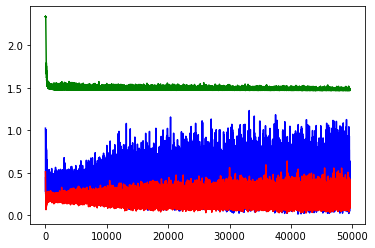

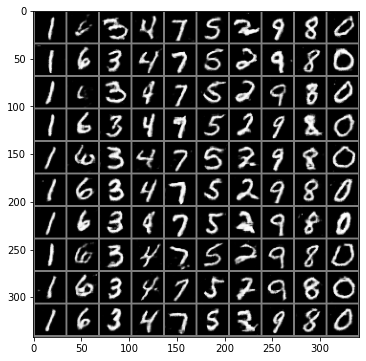

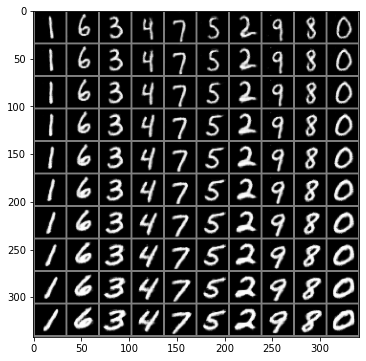

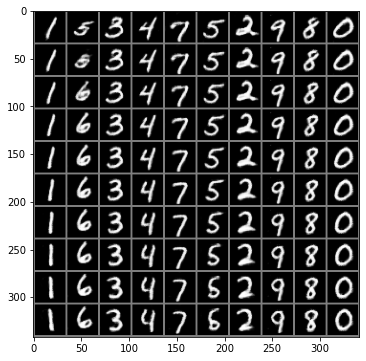

[Epoch 52/200] [Batch 825/938] [D loss: 0.095120] [G loss: 0.587199] [Info loss: 1.469934]
[Epoch 52/200] [Batch 826/938] [D loss: 0.188518] [G loss: 0.437190] [Info loss: 1.477143]
[Epoch 52/200] [Batch 827/938] [D loss: 0.279894] [G loss: 0.320381] [Info loss: 1.485347]
[Epoch 52/200] [Batch 828/938] [D loss: 0.251526] [G loss: 0.502351] [Info loss: 1.476354]
[Epoch 52/200] [Batch 829/938] [D loss: 0.149919] [G loss: 0.575664] [Info loss: 1.473854]
[Epoch 52/200] [Batch 830/938] [D loss: 0.155119] [G loss: 0.817451] [Info loss: 1.485228]
[Epoch 52/200] [Batch 831/938] [D loss: 0.285803] [G loss: 0.267843] [Info loss: 1.474163]
[Epoch 52/200] [Batch 832/938] [D loss: 0.159520] [G loss: 0.777901] [Info loss: 1.469969]
[Epoch 52/200] [Batch 833/938] [D loss: 0.078551] [G loss: 0.462594] [Info loss: 1.471057]
[Epoch 52/200] [Batch 834/938] [D loss: 0.344128] [G loss: 0.610184] [Info loss: 1.473300]
[Epoch 52/200] [Batch 835/938] [D loss: 0.086123] [G loss: 0.433338] [Info loss: 1.479481]

KeyboardInterrupt: 

In [14]:
G=G.to(device)
D=D.to(device)
G.apply(weight_init)
D.apply(weight_init)
from IPython.display import clear_output
from tqdm import tqdm
gloss_list=[]
dloss_list=[]
infoloss_list=[]
for epoch in range(epochs):
    for i,(imgs,labels) in enumerate(dataloader):
        
        
        batch_size = imgs.shape[0]
        valid=torch.ones((batch_size,1)).to(device)
        fake=torch.zeros((batch_size,1)).to(device)
        
        real_imgs=imgs.to(device)
        labels= to_categorical(labels.numpy(), n_class)
        #训练生成器
        optimizer_G.zero_grad()
        
        z = FloatTensor(np.random.normal(0, 1, (batch_size, z_dim)))
        label_input = to_categorical(np.random.randint(0, n_class, batch_size), n_class)
        code_input = FloatTensor(np.random.uniform(-1, 1, (batch_size, code_dim)))
        
        gen_imgs = G(z, label_input, code_input)
        validity, _, _ = D(gen_imgs)
        g_loss = discri_loss(validity, valid)

        g_loss.backward()
        optimizer_G.step()
        
        #print(gen_imgs.shape)
        #训练判别器
        optimizer_D.zero_grad()

        # Loss for real images
        real_pred, _, _ = D(real_imgs)
        d_real_loss = discri_loss(real_pred, valid)

        # Loss for fake images
        fake_pred, _, _ = D(gen_imgs.detach())
        d_fake_loss = discri_loss(fake_pred, fake)

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        #print(d_loss.item())
        
        #计算互信息损失
        # ------------------
        # Information Loss
        # ------------------

        optimizer_info.zero_grad()

        # Sample labels
        sampled_labels = np.random.randint(0, n_class, batch_size)

        # Ground truth labels
        gt_labels =LongTensor(sampled_labels)

        # Sample noise, labels and code as generator input
        z = FloatTensor(np.random.normal(0, 1, (batch_size, z_dim)))
        label_input = to_categorical(sampled_labels, n_class)
        code_input = FloatTensor(np.random.uniform(-1, 1, (batch_size, code_dim)))

        gen_imgs = G(z, label_input, code_input)
        _, pred_label, pred_code = D(gen_imgs)
        
        info_loss = lambda_cat * categorical_loss(
            pred_label, gt_labels) + lambda_con * continuous_loss(pred_code, code_input)

        info_loss.backward()
        optimizer_info.step()
        #print(info_loss.item())
        
        gloss_list.append(g_loss.item())
        dloss_list.append(d_loss.item())
        infoloss_list.append(info_loss.item())
        
        batch_done=i+epoch*len(dataloader)
        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f] [Info loss: %f]"
            % (epoch, epochs, i, len(dataloader), d_loss.item(), g_loss.item(),info_loss.item())
        )
        if batch_done%400==0:
            clear_output()
            
            #print(len(gloss_list))
            plt.plot(range(batch_done+1),gloss_list,color='b')
            plt.plot(range(batch_done+1),dloss_list,color='r')
            plt.plot(range(batch_done+1),infoloss_list,color='g')
            plt.show()
            draw_(batch_done)
        #break
        

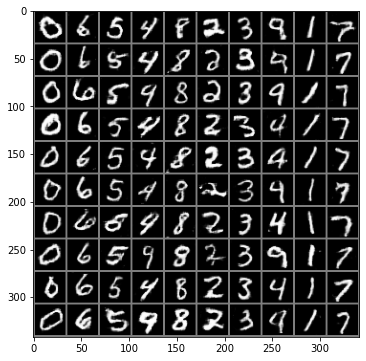

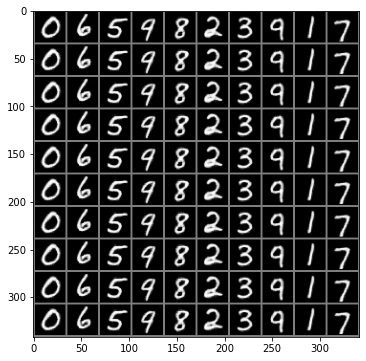

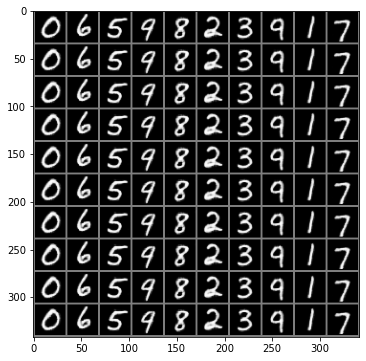

In [68]:
n_row=10
z=torch.Tensor(np.random.normal(0, 1, (n_row ** 2, z_dim))).to(device)
static_sample = G(z, static_label, static_code)
## c1,c2
zeros = np.zeros((n_row ** 2, 1))
c_varied = np.repeat(np.linspace(-1, 1, n_row)[:, np.newaxis], n_row, 0)
c1 = torch.Tensor(np.concatenate((c_varied, zeros), -1)).to(device)
c2 = torch.Tensor(np.concatenate((zeros, c_varied), -1)).to(device)
#print(static_label)
#print(c2)
sample1 = G(static_z, static_label, c1)
sample2 = G(static_z, static_label, c2)
show(static_sample)
show(sample1)
show(sample2)

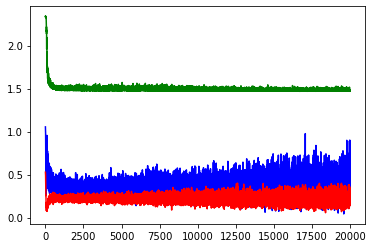

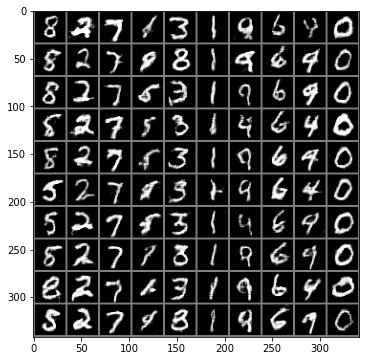

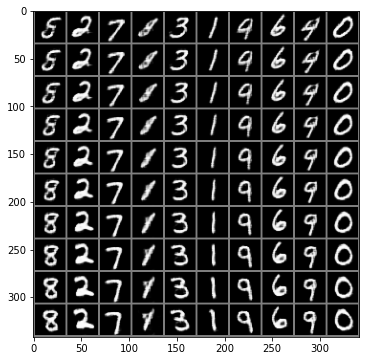

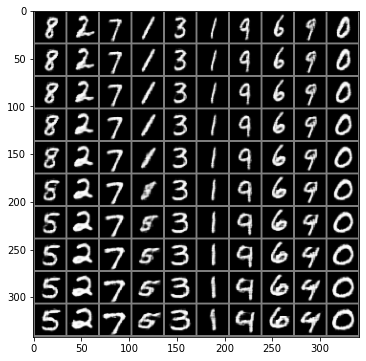

[Epoch 21/200] [Batch 303/938] [D loss: 0.174800] [G loss: 0.284400] [info loss: 1.468760]
[Epoch 21/200] [Batch 304/938] [D loss: 0.283979] [G loss: 0.380363] [info loss: 1.472746]
[Epoch 21/200] [Batch 305/938] [D loss: 0.217709] [G loss: 0.202103] [info loss: 1.492115]
[Epoch 21/200] [Batch 306/938] [D loss: 0.202828] [G loss: 0.251846] [info loss: 1.472838]
[Epoch 21/200] [Batch 307/938] [D loss: 0.234769] [G loss: 0.424707] [info loss: 1.491715]
[Epoch 21/200] [Batch 308/938] [D loss: 0.176199] [G loss: 0.314225] [info loss: 1.469288]
[Epoch 21/200] [Batch 309/938] [D loss: 0.183553] [G loss: 0.281921] [info loss: 1.483308]
[Epoch 21/200] [Batch 310/938] [D loss: 0.183970] [G loss: 0.325899] [info loss: 1.475804]
[Epoch 21/200] [Batch 311/938] [D loss: 0.192961] [G loss: 0.271465] [info loss: 1.492841]
[Epoch 21/200] [Batch 312/938] [D loss: 0.159642] [G loss: 0.240250] [info loss: 1.476124]
[Epoch 21/200] [Batch 313/938] [D loss: 0.207547] [G loss: 0.297927] [info loss: 1.484780]

KeyboardInterrupt: 

In [1]:
import argparse
import os
import numpy as np
import math
import itertools

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
from IPython.display import clear_output
import torch.nn as nn
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt
import torchvision
os.makedirs("images/static/", exist_ok=True)
os.makedirs("images/varying_c1/", exist_ok=True)
os.makedirs("images/varying_c2/", exist_ok=True)

parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=200, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=64, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--latent_dim", type=int, default=62, help="dimensionality of the latent space")
parser.add_argument("--code_dim", type=int, default=2, help="latent code")
parser.add_argument("--n_classes", type=int, default=10, help="number of classes for dataset")
parser.add_argument("--img_size", type=int, default=32, help="size of each image dimension")
parser.add_argument("--channels", type=int, default=1, help="number of image channels")
parser.add_argument("--sample_interval", type=int, default=400, help="interval between image sampling")
opt = parser.parse_args([])
print(opt)

cuda = True if torch.cuda.is_available() else False


def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


def to_categorical(y, num_columns):
    """Returns one-hot encoded Variable"""
    y_cat = np.zeros((y.shape[0], num_columns))
    y_cat[range(y.shape[0]), y] = 1.0

    return Variable(FloatTensor(y_cat))


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        input_dim = opt.latent_dim + opt.n_classes + opt.code_dim

        self.init_size = opt.img_size // 4  # Initial size before upsampling
        self.l1 = nn.Sequential(nn.Linear(input_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, opt.channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, noise, labels, code):
        gen_input = torch.cat((noise, labels, code), -1)
        out = self.l1(gen_input)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            """Returns layers of each discriminator block"""
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.conv_blocks = nn.Sequential(
            *discriminator_block(opt.channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = opt.img_size // 2 ** 4

        # Output layers
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1))
        self.aux_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, opt.n_classes), nn.Softmax())
        self.latent_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, opt.code_dim))

    def forward(self, img):
        out = self.conv_blocks(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)
        label = self.aux_layer(out)
        latent_code = self.latent_layer(out)

        return validity, label, latent_code


# Loss functions
adversarial_loss = torch.nn.MSELoss()
categorical_loss = torch.nn.CrossEntropyLoss()
continuous_loss = torch.nn.MSELoss()

# Loss weights
lambda_cat = 1
lambda_con = 0.1

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()
    categorical_loss.cuda()
    continuous_loss.cuda()

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Configure data loader
os.makedirs("../../data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(opt.img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=opt.batch_size,
    shuffle=True,
)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_info = torch.optim.Adam(
    itertools.chain(generator.parameters(), discriminator.parameters()), lr=opt.lr, betas=(opt.b1, opt.b2)
)

FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

# Static generator inputs for sampling
static_z = Variable(FloatTensor(np.zeros((opt.n_classes ** 2, opt.latent_dim))))
static_label = to_categorical(
    np.array([num for _ in range(opt.n_classes) for num in range(opt.n_classes)]), num_columns=opt.n_classes
)
static_code = Variable(FloatTensor(np.zeros((opt.n_classes ** 2, opt.code_dim))))


def sample_image(n_row, batches_done):
    """Saves a grid of generated digits ranging from 0 to n_classes"""
    # Static sample
    z = Variable(FloatTensor(np.random.normal(0, 1, (n_row ** 2, opt.latent_dim))))
    static_sample = generator(z, static_label, static_code)
    save_image(static_sample.data, "images/static/%d.png" % batches_done, nrow=n_row, normalize=True)

    # Get varied c1 and c2
    zeros = np.zeros((n_row ** 2, 1))
    c_varied = np.repeat(np.linspace(-1, 1, n_row)[:, np.newaxis], n_row, 0)
    c1 = Variable(FloatTensor(np.concatenate((c_varied, zeros), -1)))
    c2 = Variable(FloatTensor(np.concatenate((zeros, c_varied), -1)))
    sample1 = generator(static_z, static_label, c1)
    sample2 = generator(static_z, static_label, c2)
    save_image(sample1.data, "images/varying_c1/%d.png" % batches_done, nrow=n_row, normalize=True)
    save_image(sample2.data, "images/varying_c2/%d.png" % batches_done, nrow=n_row, normalize=True)
def show(imgs):
    plt.figure(figsize=(6,6))
    imgs=torchvision.utils.make_grid(imgs,nrow=10,padding=2)     
    imgs=imgs.detach().cpu().numpy().transpose(1, 2, 0)
    plt.imshow(imgs*0.5+0.5)
    plt.show()
def draw_1(batches_done,n_row=10):
    ## static
    z=Variable(FloatTensor(np.random.normal(0, 1, (n_row ** 2, opt.latent_dim))))
    static_sample = generator(z, static_label, static_code)
    ## c1,c2
    zeros = np.zeros((n_row ** 2, 1))
    c_varied = np.repeat(np.linspace(-1, 1, n_row)[:, np.newaxis], n_row, 0)
    c1 = Variable(FloatTensor(np.concatenate((c_varied, zeros), -1)))
    c2 = Variable(FloatTensor(np.concatenate((zeros, c_varied), -1)))
    
    sample1 = generator(static_z, static_label, c1)
    sample2 = generator(static_z, static_label, c2)
    show(static_sample)
    show(sample1)
    show(sample2)
    save_image(sample1.data, "varying_c1%d.png" % batches_done, nrow=n_row, normalize=True)
    save_image(sample2.data, "varying_c2%d.png" % batches_done, nrow=n_row, normalize=True)
    save_image(static_sample.data, "static%d.png" % batches_done, nrow=n_row, normalize=True)
# ----------
#  Training
# ----------
gloss_list=[]
dloss_list=[]
infoloss_list=[]
for epoch in range(opt.n_epochs):
    for i, (imgs, labels) in enumerate(dataloader):

        batch_size = imgs.shape[0]

        # Adversarial ground truths
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(FloatTensor))
        labels = to_categorical(labels.numpy(), num_columns=opt.n_classes)

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise and labels as generator input
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, opt.latent_dim))))
        label_input = to_categorical(np.random.randint(0, opt.n_classes, batch_size), num_columns=opt.n_classes)
        code_input = Variable(FloatTensor(np.random.uniform(-1, 1, (batch_size, opt.code_dim))))

        # Generate a batch of images
        gen_imgs = generator(z, label_input, code_input)

        # Loss measures generator's ability to fool the discriminator
        validity, _, _ = discriminator(gen_imgs)
        g_loss = adversarial_loss(validity, valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss for real images
        real_pred, _, _ = discriminator(real_imgs)
        d_real_loss = adversarial_loss(real_pred, valid)

        # Loss for fake images
        fake_pred, _, _ = discriminator(gen_imgs.detach())
        d_fake_loss = adversarial_loss(fake_pred, fake)

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        # ------------------
        # Information Loss
        # ------------------

        optimizer_info.zero_grad()

        # Sample labels
        sampled_labels = np.random.randint(0, opt.n_classes, batch_size)

        # Ground truth labels
        gt_labels = Variable(LongTensor(sampled_labels), requires_grad=False)

        # Sample noise, labels and code as generator input
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, opt.latent_dim))))
        label_input = to_categorical(sampled_labels, num_columns=opt.n_classes)
        code_input = Variable(FloatTensor(np.random.uniform(-1, 1, (batch_size, opt.code_dim))))

        gen_imgs = generator(z, label_input, code_input)
        _, pred_label, pred_code = discriminator(gen_imgs)

        info_loss = lambda_cat * categorical_loss(pred_label, gt_labels) + lambda_con * continuous_loss(
            pred_code, code_input
        )

        info_loss.backward()
        optimizer_info.step()
        
        
        # --------------
        # Log Progress
        # --------------
        gloss_list.append(g_loss.item())
        dloss_list.append(d_loss.item())
        infoloss_list.append(info_loss.item())
            
        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f] [info loss: %f]"
            % (epoch, opt.n_epochs, i, len(dataloader), d_loss.item(), g_loss.item(), info_loss.item())
        )
        batches_done = epoch * len(dataloader) + i
        if batches_done % opt.sample_interval == 0:
            clear_output()
            plt.plot(range(batches_done+1),gloss_list,color='b')
            plt.plot(range(batches_done+1),dloss_list,color='r')
            plt.plot(range(batches_done+1),infoloss_list,color='g')
            plt.show()
            draw_1(batches_done)
            #sample_image(n_row=10, batches_done=batches_done)
